In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from collections import Counter


In [2]:
# Get the list of stopwords

nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Konstantinos
[nltk_data]     Razgkel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = pd.read_csv("data/training_data.tsv.gz", sep="\t", header=None)
dataset.dropna(inplace=True)

C:\Users\Konstantinos Razgkel\AppData\Local\Temp\ipykernel_13996\1873620785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={0: 'index', 1: 'title', 2: 'text', 3: 'labels'}, inplace=True)
C:\Users\Konstantinos Razgkel\AppData\Local\Temp\ipykernel_13996\1873620785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', axis=1, inplace=True)
C:\Users\Konstantinos Razgkel\PycharmProjects\DataMine\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the war

Silhouette Coefficient: 0.2098054182164736


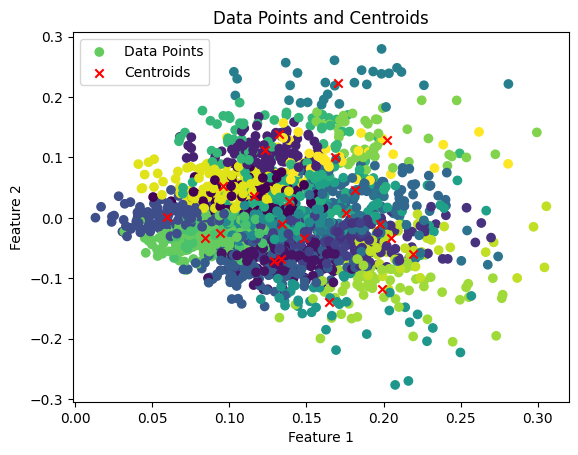

In [100]:
df = dataset.head(10000)

df.rename(columns={0: 'index', 1: 'title', 2: 'text', 3: 'labels'}, inplace=True)
df.drop('index', axis=1, inplace=True)

X = df.drop('labels', axis=1)
X = X.applymap(lambda x: re.sub(r'<.*?>|[^\w\s]', '', x.lower())).applymap(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))


unique_labels = df['labels'].unique()
n_clusters = len(unique_labels)

#label_dict = {i: label for i, label in enumerate(unique_labels)}

y = df['labels']
X  = X["title"] + X["text"]

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data
X = vectorizer.fit_transform(X)

pca = TruncatedSVD(n_components=3)
X = pca.fit_transform(X)

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the KNN classifier
kmeans = KMeans(n_clusters=n_clusters)

# Train the KNN classifier
kmeans.fit(X_train, y_train)

# Make predictions on the test set
y_pred = kmeans.predict(X_test)


# Create a dictionary to store the assigned cluster for each label
label_cluster_dict = {}

# Iterate over each label and its corresponding predicted cluster label
for label, cluster in zip(y, y_pred):
    # Check if the label is already in the dictionary
    if label not in label_cluster_dict:
        # If the label doesn't exist, assign the cluster to the label
        label_cluster_dict[label] = cluster

# Print the assigned cluster for each label
label_dict = {label: cluster for label, cluster in label_cluster_dict.items()}

silhouette_coefficient = silhouette_score(X_test, y_pred)
print("Silhouette Coefficient:", silhouette_coefficient)

centroids = kmeans.cluster_centers_

# Plot the data points and centroids
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and Centroids')
plt.legend(['Data Points', 'Centroids'])

# Show the plot
plt.show()

In [47]:
from collections import defaultdict

# Get the predicted labels for the training set
y_pred_train = kmeans.labels_

# Create a dictionary to store centroid labels
centroid_labels = defaultdict(list)

# Assign labels per centroid
for i, label in enumerate(y_pred_train):
    centroid_labels[label].append(y_train.iloc[i].idxmax())

# Print the centroid labels
for centroid, labels in centroid_labels.items():
    print(f"Centroid {centroid} labels: {labels}")

AttributeError: 'str' object has no attribute 'idxmax'

In [80]:
predict = pd.DataFrame(y_pred)
predict.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

results = pd.concat([y_test, predict], axis=1)
results.rename(columns={"labels": "Actual Label", 0: 'Predicted Label'}, inplace=True)
results
#correct_predictions = results[results['Predicted Label'] == results['Actual Label']]

# pd.concat([y_test, predict], axis=1)

,Actual Label,Predicted Label
0,"jquery,css",6
1,jquery,21
2,javascript,6
3,"javascript,jquery",15
4,"javascript,jquery",2
...,...,...
1995,html,11
1996,javascript,4
1997,javascript,6
1998,"jquery,html,css",8


In [20]:
# Get the predicted labels for the training set
y_pred_train = kmeans.labels_

# Create a dictionary to store cluster labels
cluster_labels = {}

# Assign labels to clusters
for i, label in enumerate(y_pred_train):
    if label not in cluster_labels:
        cluster_labels[label] = []
    cluster_labels[label].append(y_train.iloc[i].idxmax())

# Get the majority label for each cluster
majority_labels = {}
for cluster, labels in cluster_labels.items():
    counter = Counter(labels)
    majority_labels[cluster] = counter.most_common(1)[0][0]

# Print the cluster labels
for cluster, label in majority_labels.items():
    print(f"Cluster {cluster} label: {label}")

Cluster 1 label: css
Cluster 0 label: javascript
Cluster 2 label: javascript
Cluster 3 label: javascript


In [94]:
# Create a dictionary to store the assigned cluster for each label
label_cluster_dict = {}

# Iterate over each label and its corresponding predicted cluster label
for label, cluster in zip(y, y_pred):
    # Check if the label is already in the dictionary
    if label not in label_cluster_dict:
        # If the label doesn't exist, assign the cluster to the label
        label_cluster_dict[label] = cluster

# Print the assigned cluster for each label
for label, cluster in label_cluster_dict.items():
    print(f"Label: {label}, Cluster: {cluster}")

Label: html,css, Cluster: 19
Label: javascript,html, Cluster: 12
Label: html, Cluster: 19
Label: javascript, Cluster: 10
Label: css, Cluster: 8
Label: javascript,css, Cluster: 19
Label: javascript,jquery, Cluster: 2
Label: javascript,html,css, Cluster: 6
Label: javascript,jquery,html, Cluster: 2
Label: jquery, Cluster: 9
Label: jquery,html, Cluster: 9
Label: css,html, Cluster: 10
Label: javascript,jquery,css, Cluster: 16
Label: javascript,jquery,html,css, Cluster: 18
Label: html,javascript, Cluster: 5
Label: jquery,css, Cluster: 10
Label: javascript,css,html, Cluster: 0
Label: jquery,html,css, Cluster: 5


18

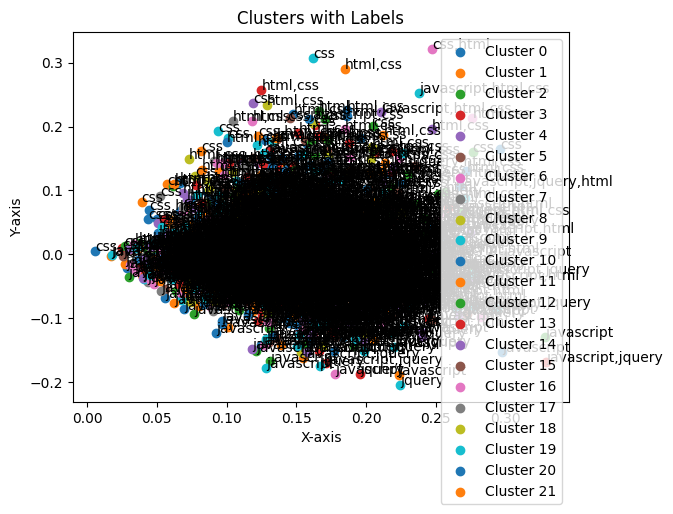

In [99]:
X

array([[ 0.12211399,  0.17025866],
       [ 0.11243178, -0.00603055],
       [ 0.14184982, -0.04553174],
       ...,
       [ 0.07481183, -0.02200107],
       [ 0.14487868,  0.08394302],
       [ 0.22616274, -0.0030215 ]])

,0
count,1.901102e+06
mean,2.497909e+07
std,1.268254e+07
min,6.000000e+00
25%,1.450010e+07
50%,2.540321e+07
75%,3.595502e+07
max,4.590167e+07


In [103]:
from sklearn.preprocessing import StandardScaler


dataset = pd.read_csv("data/training_data.tsv.gz", sep="\t", header=None)
dataset.dropna(inplace=True)

In [105]:
#scaler = StandardScaler()


In [108]:
print(dataset)

In [110]:
# Initialize empty list to store the sum of squared distances
sse = []

# Try different values of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the sum of squared distances
plt.plot(range(1, 11), sse)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()